# NSCI 274 Research Project - DOPEamine

### Comparing firing rates over time in the dentate gyrus between male and female mice

## Environment Set-Up

### Installing AllenSDK

In [1]:
pip install allensdk

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Import Packages

In [2]:
import os
import shutil
import allensdk
import pprint
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

### Neuropixels Visual Behavior Data

In [3]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

data_directory = Path("/overflow/NSCI274/projects/EcephysBehaviorData/")

cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=data_directory)

## Separating Male and Female Sessions in DG

Sorting for DG-sg and reward type EPHYS_1_images_H_3uL_reward

In [4]:
ecephys_session_table = cache.get_ecephys_session_table()
ecephys_session_table

female_sessions = ecephys_session_table [(ecephys_session_table.sex == 'F') & \
                            (['DG-sg' in acronyms for acronyms in ecephys_session_table.structure_acronyms]) & \
                                       (ecephys_session_table.session_type == 'EPHYS_1_images_H_3uL_reward')]

male_sessions = ecephys_session_table [(ecephys_session_table.sex == 'M') & \
                            (['DG-sg' in acronyms for acronyms in ecephys_session_table.structure_acronyms]) & \
                                       (ecephys_session_table.session_type == 'EPHYS_1_images_H_3uL_reward')]

#### Obtain list of ID numbers from male and female sessions
List of integers

In [5]:
female_session_ids = []
for session_id in female_sessions.index:
    female_session_ids.append(session_id)
male_session_ids = []
for session_id in male_sessions.index:
    male_session_ids.append(session_id)
    


#### Test Session

Used for testing code before running it through for loops

In [6]:
test_session =  cache.get_ecephys_session(ecephys_session_id=female_session_ids[0])
print(test_session)

test_units = cache.get_unit_table()

session_units = test_units[test_units['ecephys_session_id']==female_session_ids[0]]
session_units_DG = session_units [session_units.structure_acronym == 'DG']

/nas/longleaf/home/eseith/.local/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [7]:
session_id = female_session_ids[0]
session = cache.get_ecephys_session(
            ecephys_session_id=session_id)

units = session.get_units()
channels = session.get_channels()

unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)

DG_unit_channels = unit_channels[(unit_channels.structure_acronym == 'DG')]

unit_channels = unit_channels.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them
good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))

good_units = unit_channels.loc[good_unit_filter]
spike_times = session.spike_times
stimulus_presentations = test_session.stimulus_presentations
change_times = stimulus_presentations[stimulus_presentations['active']&
                            stimulus_presentations['is_change']]['start_time'].values

def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/startTimes.size
    return counts/binSize, bins

area_of_interest = 'DG'
area_change_responses = []
area_units = good_units[good_units['structure_acronym']==area_of_interest]
time_before_change = 1
duration = 2.5
for iu, unit in area_units.iterrows():
    unit_spike_times = spike_times[iu]
    unit_change_response, bins_F = makePSTH(unit_spike_times, 
                                          change_times-time_before_change, 
                                          duration, binSize=0.01)
    area_change_responses.append(unit_change_response)
area_change_responses = np.array(area_change_responses)

In [8]:
session_id = male_session_ids[0]
session = cache.get_ecephys_session(
            ecephys_session_id=session_id)

units = session.get_units()
channels = session.get_channels()

unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)

DG_unit_channels = unit_channels[(unit_channels.structure_acronym == 'DG')]

unit_channels = unit_channels.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them
good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))

good_units = unit_channels.loc[good_unit_filter]
spike_times = session.spike_times
stimulus_presentations = test_session.stimulus_presentations
change_times = stimulus_presentations[stimulus_presentations['active']&
                            stimulus_presentations['is_change']]['start_time'].values

def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/startTimes.size
    return counts/binSize, bins

area_of_interest = 'DG'
area_change_responses = []
area_units = good_units[good_units['structure_acronym']==area_of_interest]
time_before_change = 1
duration = 2.5
for iu, unit in area_units.iterrows():
    unit_spike_times = spike_times[iu]
    unit_change_response, bins_M = makePSTH(unit_spike_times, 
                                          change_times-time_before_change, 
                                          duration, binSize=0.01)
    area_change_responses.append(unit_change_response)
area_change_responses = np.array(area_change_responses)

## Find Array of Firing Rates corresponding to Time over Session

#### Defining Functions Used

In [9]:
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/startTimes.size
    return counts/binSize, bins

In [10]:
def FiringRatePSTH(session_id): 
    session = cache.get_ecephys_session(
            ecephys_session_id=session_id)
    units = session.get_units() # getting all units out of session
    channels = session.get_channels() #getting all channels out of session

    unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True) #combining units and channels data

    DG_unit_channels = unit_channels[(unit_channels.structure_acronym == 'DG')] # filtering units/channels for DG

    #sorting units by depth
    unit_channels = unit_channels.sort_values('probe_vertical_position', ascending=False)

    #now we'll filter them for good quality
    good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))

    good_units = unit_channels.loc[good_unit_filter]
    spike_times = session.spike_times
    
    stimulus_presentations = test_session.stimulus_presentations
    change_times = stimulus_presentations[stimulus_presentations['active']&
                            stimulus_presentations['is_change']]['start_time'].values
    
    area_of_interest = 'DG'
    area_change_responses = []
    area_units = good_units[good_units['structure_acronym']==area_of_interest]
    time_before_change = 1
    duration = 2.5
    for iu, unit in area_units.iterrows():
        unit_spike_times = spike_times[iu]
        unit_change_response, bins = makePSTH(unit_spike_times, 
                                              change_times-time_before_change, 
                                              duration, binSize=0.01)
        area_change_responses.append(unit_change_response)
    area_change_responses = np.array(area_change_responses)
    
    return area_change_responses

### Female Mice

In [11]:
all_session_PSTH_F = []
for session_id in female_session_ids: 
    print(count)
    session_PSTH_F = FiringRatePSTH(session_id)
    session_PSTH_F_array = np.array(session_PSTH_F)
    all_session_PSTH_F.append(session_PSTH_F)
    if count == 1: 
        mass_array_F = session_PSTH_F_array
    else: 
        concatenated_array = np.concatenate((mass_array_F, session_PSTH_F_array))
        
print(concatenated_array)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
[[0.84388186 0.84388186 0.42194093 ... 0.         0.84388186 1.26582278]
 [0.         0.84388186 0.84388186 ... 0.42194093 0.42194093 0.84388186]
 [9.28270042 6.75105485 6.75105485 ... 3.79746835 4.64135021 4.64135021]
 ...
 [0.84388186 0.42194093 0.         ... 1.26582278 0.         2.10970464]
 [0.         0.         0.42194093 ... 0.84388186 0.         0.        ]
 [1.68776371 0.         1.26582278 ... 0.84388186 0.42194093 0.        ]]


In [51]:
savetxt('female_all_units.csv', concatenated_array, delimiter = ',')
savetxt('one_female_unit.csv', concatenated_array[0], delimiter = ',')

#### Make PSTH Graph with Female Mice Data

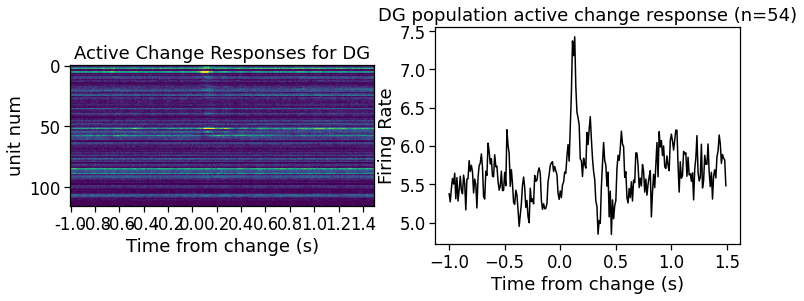

In [12]:
fig, ax = plt.subplots(1,2)
# fig, ax = plt.subplots(1,1)
fig.set_size_inches([12,4])

data_entered_F = concatenated_array

clims = [np.percentile(data_entered_F, p) for p in (0.1,99.9)]
im = ax[0].imshow(data_entered_F, clim=clims)
ax[0].set_title('Active Change Responses for {}'.format(area_of_interest))
ax[0].set_ylabel('unit num') #'Unit number, sorted by depth'
ax[0].set_xlabel('Time from change (s)')
ax[0].set_xticks(np.arange(0, bins_F.size-1, 20))
_ = ax[0].set_xticklabels(np.round(bins_F[:-1:20]-time_before_change, 2))

ax[1].plot(bins_F[:-1]-time_before_change, np.mean(data_entered_F, axis=0), 'k')
ax[1].set_title('{} population active change response (n={})'\
                .format(area_of_interest, area_change_responses.shape[0]))
ax[1].set_xlabel('Time from change (s)')
ax[1].set_ylabel('Firing Rate')

# ax.plot(bins_F[:-1]-time_before_change, np.mean(data_entered_F, axis=0), 'k')
# ax.set_title('{} population active change response (n={})'\
#                 .format(area_of_interest, area_change_responses.shape[0]))
# ax.set_xlabel('Time from change (s)')
# ax.set_ylabel('Firing Rate')

fig.savefig('FemaleAverageFiringRateChange')

#### Sample Raster Plot of First 50 units for Female Mice Data

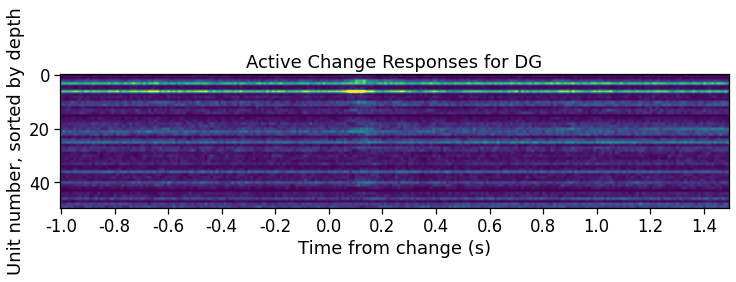

In [48]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches([12,4])

clims = [np.percentile(data_entered_F[:50], p) for p in (0.1,99.9)]
im = ax.imshow(data_entered_F[:50], clim=clims)
ax.set_title('Active Change Responses for {}'.format(area_of_interest))
ax.set_ylabel('Unit number, sorted by depth')
ax.set_xlabel('Time from change (s)')
ax.set_xticks(np.arange(0, bins_F.size-1, 20))
_ = ax.set_xticklabels(np.round(bins_F[:-1:20]-time_before_change, 2))

fig.savefig('First_50_units_female_raster')

#### Constructing Array of Means For Each Time Interval Across All Cells

In [14]:
mean_concatenated_array = np.mean(concatenated_array, axis=0)
print(mean_concatenated_array) #mean_concatonated array IS THE Y VALUES IN PSTH ABOVE (FEMALE DATA)

[5.37610941 5.27062418 5.44158301 5.57616761 5.50341918 5.64527863
 5.31063582 5.58707988 5.28153645 5.42703332 5.60526699 5.42703332
 5.37610941 5.61981667 5.51069402 5.16513895 5.56889277 5.57253019
 5.80896261 5.66710316 5.74712644 5.66346574 5.38702168 5.56889277
 5.49614433 5.1906009  5.58707988 5.74348901 5.77622581 5.89626073
 5.72166448 5.3397352  5.3069984  5.67074058 5.61617925 6.03812018
 5.92899753 5.76531355 5.83442456 5.60526699 5.59799214 5.88534847
 5.72893933 5.73621417 5.53979339 5.4233959  5.4743198  5.67074058
 5.41612105 5.4233959  5.65619089 5.48159465 6.21271643 6.00902081
 5.907173   5.4743198  5.69256511 5.5070566  5.25971192 5.23788739
 5.4233959  5.3579223  5.16877637 4.95053106 5.1069402  5.24879965
 5.48523207 5.59435472 5.45613269 5.19787575 5.28881129 5.07784083
 4.99781755 5.44885785 5.2742616  5.31063582 5.24516223 5.61617925
 5.53979339 5.55434308 5.66346574 5.71438964 5.6416412  5.29244871
 5.17241379 5.24516223 5.17968864 5.18696348 5.24879965 5.5325

#### Constructing array of medians for female mice data

In [15]:
median_concatenated_array_F = np.median(concatenated_array, axis=0)
print(median_concatenated_array_F)

[2.9535865  2.74261603 3.37552743 2.9535865  3.37552743 3.58649789
 3.37552743 3.37552743 3.58649789 3.37552743 3.37552743 3.37552743
 2.9535865  3.37552743 3.16455696 2.9535865  2.9535865  2.9535865
 3.37552743 3.79746835 3.79746835 3.37552743 3.16455696 3.37552743
 2.9535865  2.9535865  2.9535865  3.37552743 3.37552743 4.21940928
 3.37552743 3.37552743 3.16455696 3.16455696 3.37552743 2.9535865
 3.37552743 3.37552743 4.00843882 3.16455696 3.16455696 3.79746835
 3.79746835 3.79746835 2.9535865  2.9535865  2.9535865  3.37552743
 3.37552743 2.9535865  3.37552743 2.9535865  3.37552743 3.79746835
 3.79746835 4.00843882 3.37552743 4.21940928 3.37552743 3.37552743
 2.9535865  3.37552743 3.37552743 2.9535865  3.16455696 2.9535865
 3.79746835 3.79746835 3.37552743 3.16455696 3.37552743 3.37552743
 2.9535865  3.37552743 2.9535865  2.9535865  2.9535865  3.37552743
 3.37552743 3.58649789 3.79746835 3.37552743 3.58649789 3.79746835
 3.37552743 2.9535865  2.9535865  3.37552743 2.9535865  3.7974683

### Male Mice

In [19]:
for session_id in male_session_ids: 
    print(count_M)
    session_PSTH_M = FiringRatePSTH(session_id)
    session_PSTH_M = np.array(session_PSTH_M)
    if count_M == 1: 
        mass_array_M = session_PSTH_M
    else: 
        mass_array_M = np.concatenate((mass_array_M, session_PSTH_M))

1


/nas/longleaf/home/eseith/.local/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [52]:
savetxt('male_all_units.csv', mass_array_M, delimiter = ',')

#### Make PSTH with Male Data

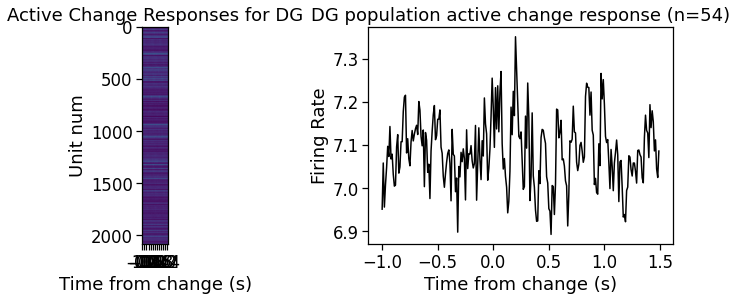

In [20]:
fig, ax = plt.subplots(1,2)
# fig, ax = plt.subplots(1,1)
fig.set_size_inches([12,4])

data_entered_M = mass_array_M

clims = [np.percentile(data_entered_M, p) for p in (0.1,99.9)]
im = ax[0].imshow(data_entered_M, clim=clims)
ax[0].set_title('Active Change Responses for {}'.format(area_of_interest))
ax[0].set_ylabel('Unit num')
ax[0].set_xlabel('Time from change (s)')
ax[0].set_xticks(np.arange(0, bins_M.size-1, 20))
_ = ax[0].set_xticklabels(np.round(bins_M[:-1:20]-time_before_change, 2))

ax[1].plot(bins_M[:-1]-time_before_change, np.mean(data_entered_M, axis=0), 'k')
ax[1].set_title('{} population active change response (n={})'\
                .format(area_of_interest, area_change_responses.shape[0]))
ax[1].set_xlabel('Time from change (s)')
ax[1].set_ylabel('Firing Rate')


#### Sample Raster Plot of First 50 Units from Male Data

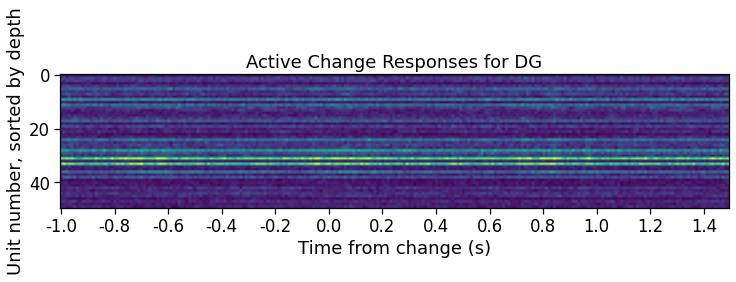

In [49]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches([12,4])

clims = [np.percentile(data_entered_M[:50], p) for p in (0.1,99.9)]
im = ax.imshow(data_entered_M[:50], clim=clims)
ax.set_title('Active Change Responses for {}'.format(area_of_interest))
ax.set_ylabel('Unit number, sorted by depth')
ax.set_xlabel('Time from change (s)')
ax.set_xticks(np.arange(0, bins_F.size-1, 20))


_ = ax.set_xticklabels(np.round(bins_F[:-1:20]-time_before_change, 2))

fig.savefig('First_50_units_male_raster')

In [22]:
mean_concatenated_array_M = np.mean(mass_array_M, axis=0)
print(mean_concatenated_array_M) #mean_concatenated_array_M IS Y-VALUES FOR MALE PSTH GRAPH

[6.9514009  7.0584545  6.95625778 7.0082668  7.04772891 7.09710712
 7.07342986 7.14304506 7.06776351 7.07889385 7.03214643 7.00482652
 7.00725496 7.09569054 7.12422467 7.03497961 7.04914549 7.10763035
 7.10783272 7.17744792 7.21124366 7.21549343 7.08172702 7.11471329
 7.06857299 7.05197867 7.10722561 7.13373605 7.10965405 7.12523652
 7.13798581 7.14587823 7.12442704 7.20092281 7.18109057 7.12017728
 7.09832134 7.13495027 7.0036123  7.12908154 7.11127301 7.03700331
 7.05562133 6.97609001 7.08638153 7.13171235 7.16996023 7.1916138
 7.11248723 7.12159386 7.15984175 7.16004412 7.18149531 7.0952858
 7.08111991 7.0276943  7.00219571 7.03356302 7.06007346 7.0805128
 7.08880996 7.05784739 6.9708284  7.13636686 7.07869148 7.07464408
 6.99187485 7.02364691 6.89817766 7.05035971 7.02627771 7.08314361
 7.06149005 7.0912384  7.06857299 6.9728521  7.13535501 7.04550284
 7.08010807 7.07909622 7.09872608 7.06351375 7.04691943 7.05703791
 7.14547349 6.97224499 7.05258578 7.14000951 7.06675166 7.0200042

In [54]:
savetxt('PSTH_Times.csv', bins_M[:-1]-time_before_change, delimiter = ',')

#### Convert data to DataFrame to export as .csv

In [25]:
graph_pd_M = pd.DataFrame(bins_M[:-1]-time_before_change, mean_concatenated_array_M)

graph_pd_M.to_csv('/nas/longleaf/home/eseith/MaleCSV.csv')

### Finding Average Baseline for Each Cell (MALE AND FEMALE)

Finding index value where the time change occurs

In [26]:
time_values = list(bins_F[:-1]-time_before_change)
# print(time_values)
zero_index = time_values.index(0.0)

print(zero_index)

100


Finding average baseline firing rate and response firing rates for female units

In [27]:
female_differences = []
all_baseline_aves_F = []
for F_array in concatenated_array:
    #print(F_array)
    baseline_list_F = []
    after_baseline_list_F = []
    for num in np.arange(len(F_array)): 
        if num >= 100:
            after_baseline_list_F.append(F_array[num])
        else: 
            baseline_list_F.append(F_array[num])
    # print(baseline_list_F)
    # print(after_baseline_list_F)
    baseline_array_F = np.array(baseline_list_F)
    baseline_average_F = np.average(baseline_array_F)
    all_baseline_aves_F.append(baseline_average_F)
    #print(F_array[100:], len(F_array[100:]))
    max_firing_F = np.max(after_baseline_list_F[:150])
    #print(baseline_average_F, max_firing_F)
    unit_difference_F = max_firing_F - baseline_average_F
    #print(unit_difference_F)
    female_differences.append(unit_difference_F)
    
all_baseline_aves_F = np.array(all_baseline_aves_F)


2.9746835443037973
2.7215189873417724
26.970464135021096
9.147679324894519
3.2362869198312234
4.2405063291139244
38.87763713080168
4.662447257383966
2.5147679324894514
2.8649789029535873
14.987341772151893
7.219409282700422
4.172995780590718
6.683544303797469
4.822784810126582
0.7932489451476792
3.485232067510549
5.046413502109705
5.742616033755275
4.6455696202531644
12.451476793248947
9.616033755274266
7.046413502109704
2.5738396624472575
6.244725738396625
9.10126582278481
2.594936708860759
6.227848101265822
3.8227848101265813
4.063291139240507
3.261603375527426
2.8945147679324905
4.341772151898734
6.122362869198312
2.3966244725738393
2.2067510548523206
5.632911392405061
3.6624472573839664
4.054852320675105
4.675105485232067
8.907172995780591
8.556962025316457
3.2995780590717296
0.7932489451476792
4.751054852320675
2.995780590717299
7.784810126582279
2.240506329113924
10.379746835443036
7.4683544303797476
4.7215189873417724
6.253164556962025
36.20675105485233
16.569620253164558
9.6708

Average baseline firing rate and response firing rate for male units

In [29]:
male_differences = []
all_baseline_aves_M = []
for M_array in mass_array_M: 
    baseline_list_M = []
    after_baseline_list_M = []
    for num in np.arange(len(M_array)): 
        if num >= 100:
            after_baseline_list_M.append(M_array[num])
        else: 
            baseline_list_M.append(M_array[num])
    baseline_array_M = np.array(baseline_list_M)
    baseline_average_M = np.average(baseline_array_M)
    all_baseline_aves_M.append(baseline_average_M)
    max_firing_M = np.max(after_baseline_list_M[:150])
    #print(max_firing_M, baseline_average_M)
    unit_difference_M = max_firing_M - baseline_average_M
    #print(unit_difference_M)
    male_differences.append(unit_difference_M)

all_baseline_aves_M = np.array(all_baseline_aves_M)
#print(all_baseline_aves_M)

In [32]:
print(f'median baseline firing rate for females is {np.median(np.array(all_baseline_aves_F))}')
print(f'median baseline firing rate for males is {np.median(np.array(all_baseline_aves_M))}')

median baseline firing rate for females is 3.027426160337553
median baseline firing rate for males is 4.430379746835443


In [33]:
print(f'median response firing rate for females is {np.median(np.array(female_differences))}')
print(f'median response firing rate for males is {np.median(np.array(male_differences))}')

median response firing rate for females is 4.227848101265824
median response firing rate for males is 4.0126582278481004


In [34]:
from numpy import array, savetxt
savetxt('baseline_average_male.csv', all_baseline_aves_M, delimiter = ',')
savetxt('baseline_average_female.csv', all_baseline_aves_F, delimiter = ',')

In [35]:
savetxt('differnce_female.csv', female_differences, delimiter = ',')
savetxt('difference_male.csv', male_differences, delimiter = ',')

## Statistical Analysis

#### Wilcoxen Rank-Sum Test between Baselines for Male and Female Mice

In [44]:
st.stats.ranksums(all_baseline_aves_F, all_baseline_aves_M)

RanksumsResult(statistic=-1.4471031883999481, pvalue=0.14786802517772843)

#### Wilcoxen Rank-Sum Test between Responses for Male and Female Mice

In [45]:
st.stats.ranksums(female_differences, male_differences)

RanksumsResult(statistic=0.8383456570938965, pvalue=0.4018366004830969)

In [46]:
# Perform the two sample t-test with equal variances
st.ttest_ind(a=np.array(female_differences), b=np.array(male_differences), equal_var=False)

Ttest_indResult(statistic=1.9956359514384525, pvalue=0.048283295354074315)